## Leukaemia Classification using DL

### Approach 2: ResNet50

#### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow
import os
import skimage.io
import glob
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tqdm import tqdm
from tensorflow.keras import layers

#### Data Preparation:

In [3]:
# all - positive     hem - negative
train_dataset_0_all = glob.glob('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
# train_dataset_1_all = glob.glob('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
# train_dataset_1_hem = glob.glob('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
# train_dataset_2_all = glob.glob('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
# train_dataset_2_hem = glob.glob('/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

valid_data = pd.read_csv('/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

In [4]:
positives = []
negatives = []

positives.extend(train_dataset_0_all)
# positives.extend(train_dataset_1_all)
# positives.extend(train_dataset_2_all)

negatives.extend(train_dataset_0_hem)
# negatives.extend(train_dataset_1_hem)
# negatives.extend(train_dataset_2_hem)

positives = np.array(positives)
negatives = np.array(negatives)

len(positives),len(negatives)

(2397, 1130)

In [5]:
images = []
labels = []

for i in tqdm(range(0, len(positives))):
    img = imread(positives[i])
    img = resize(img, (180,180))
    images.append(img)
    labels.append(1)
    
for i in tqdm(range(0, len(negatives))):
    img = imread(negatives[i])
    img = resize(img, (180,180))
    images.append(img)
    labels.append(0)
    
images = np.array(images)
labels = np.array(labels)

images.shape, labels.shape

100%|██████████| 1130/1130 [00:28<00:00, 40.06it/s]


((3527, 180, 180, 3), (3527,))

In [ ]:
# images, labels = shuffle(images, labels, random_state = 42)

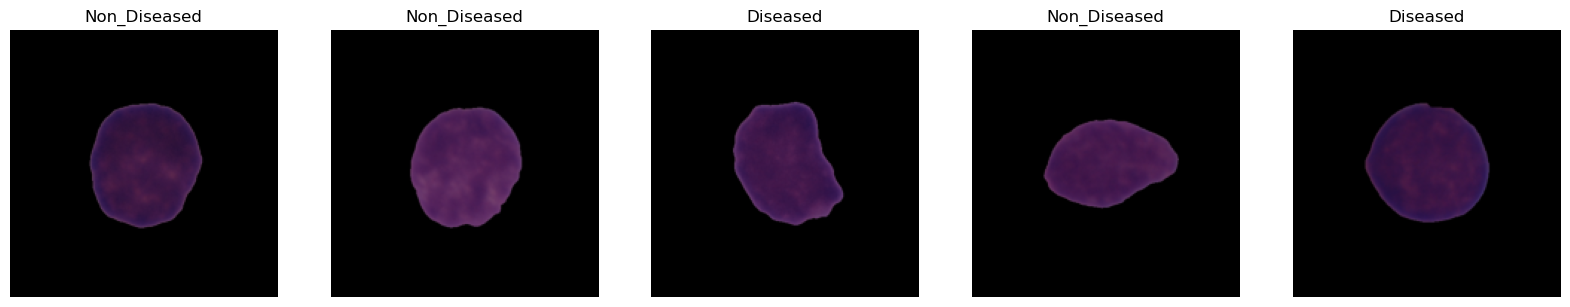

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in range(0, 5):
    rand = np.random.randint(len(images))
    ax[i].imshow(images[rand])
    ax[i].axis('off')
    a = labels[rand]
    if a == 1:
        ax[i].set_title('Diseased')
    else:
        ax[i].set_title('Non_Diseased')

In [7]:
valid_data.head()

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1


In [8]:
val_images = []

for image_name in valid_data.new_names:
    img = imread('/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/' + image_name)
    img = resize(img, (180,180))
    val_images.append(img)

val_images = np.array(val_images)

val_labels = valid_data.labels.values

In [9]:
len(val_images), len(val_labels)

(1867, 1867)

In [ ]:
# augmentation
# train_datagen  = ImageDataGenerator(horizontal_flip=True,
#                                     vertical_flip=True,
#                                     zoom_range = 0.2,
#                                     preprocessing_function=preprocess_input)
# train_datagen.fit(images)

In [10]:
# function to plote training history
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # plot results
    # accuracy
    plt.figure(figsize=(5, 8))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    # loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()

#### Model

In [11]:
model_res50 = Sequential()

model_res50.add(ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet'
    ))

model_res50.add(Dense(1, activation='sigmoid'))

model_res50.layers[0].trainable = False 

model_res50.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
model_res50.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


history = model_res50.fit(images,
                          labels, 
                          validation_data = (val_images, val_labels),
                          epochs = 15,
                          verbose = 1)

Epoch 1/15
111/111 [==============================] - 22s 108ms/step - loss: 0.6389 - accuracy: 0.6756 - val_loss: 0.6451 - val_accuracy: 0.6529
Epoch 2/15
111/111 [==============================] - 7s 67ms/step - loss: 0.6287 - accuracy: 0.6796 - val_loss: 0.6690 - val_accuracy: 0.6529
Epoch 3/15
111/111 [==============================] - 7s 67ms/step - loss: 0.6311 - accuracy: 0.6796 - val_loss: 0.6444 - val_accuracy: 0.6529
Epoch 4/15
111/111 [==============================] - 8s 70ms/step - loss: 0.6250 - accuracy: 0.6796 - val_loss: 0.6436 - val_accuracy: 0.6529
Epoch 5/15
111/111 [==============================] - 8s 68ms/step - loss: 0.6207 - accuracy: 0.6796 - val_loss: 0.6469 - val_accuracy: 0.6529
Epoch 6/15
111/111 [==============================] - 8s 68ms/step - loss: 0.6212 - accuracy: 0.6796 - val_loss: 0.6428 - val_accuracy: 0.6529
Epoch 7/15
111/111 [==============================] - 8s 68ms/step - loss: 0.6167 - accuracy: 0.6796 - val_loss: 0.6424 - val_accuracy: 0.65

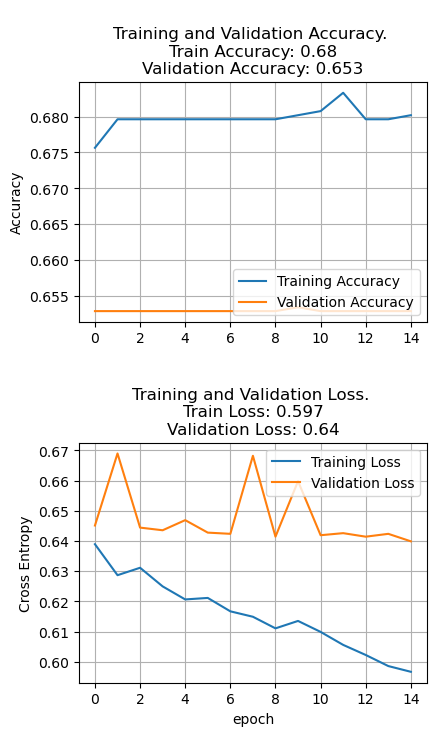

In [14]:
plot_history(history)